# Group 12 - Strategy Implementation and Backtesting

## 0. Import packages

If there are any missing packages, you can install them by typing in the code shell:
```terminal
!pip install <package_name>
```
or
```terminal
%pip install <package_name>
```

In [ ]:
import pandas as pd
import numpy as np
import psycopg
import json
import pprint
import mplfinance as mpf

from typing import List
from matplotlib import pyplot as plt
from numpy.testing import assert_almost_equal, assert_equal

## 1. Data Preparation
### 1.1. Data Importing
First, we load the data from `yfinance`:

In [171]:
# Load data
with open('database.json', 'rb') as fb:
    db_info = json.load(fb)
conn = psycopg.connect(
    host=db_info['host'],
    port=db_info['port'],
    dbname=db_info['database'],
    user=db_info['user'],
    password=db_info['password']
)
with psycopg.connect(
    host=db_info['host'],
    port=db_info['port'],
    dbname=db_info['database'],
    user=db_info['user'],
    password=db_info['password']
) as conn:
    # Open a cursor to perform database operations
    with conn.cursor() as data:
        
        # Execute a query
        data.execute("""
            SELECT m.datetime, m.tickersymbol, m.price
            FROM "quote"."matched" m
            WHERE m.tickersymbol LIKE 'VN30F23%'
            and m.datetime >= '2023-01-01 00:00:00'
        """)

        # Use fetchall() to get all the data of the query.
        # Note: fetchall() can be costly and inefficient.
        # Other efficient ways have been discussed extensively on the Internet. Or you can ask ChatGPT ;)
        dataset = data.fetchall()

        # Print the total number of ticks of that day
        print(f'Total number of tick: {len(dataset)}')

        # Pretty print the first five ticks

Total number of tick: 852871


float64
                           tickersymbol   price
datetime                                       
2023-01-03 09:00:30.560750    VN30F2301  1001.1
2023-01-03 09:00:33.543882    VN30F2301  1001.3
2023-01-03 09:00:33.674225    VN30F2301  1001.0
2023-01-03 09:00:35.285053    VN30F2301  1001.3
2023-01-03 09:00:37.309136    VN30F2301  1001.0
2023-01-03 09:00:57.061892    VN30F2301  1001.5
2023-01-03 09:00:59.101308    VN30F2301  1001.0
2023-01-03 09:01:01.636180    VN30F2301  1001.5
2023-01-03 09:01:03.180207    VN30F2301  1001.4
2023-01-03 09:01:07.520144    VN30F2301  1001.5
2023-01-03 09:01:11.581916    VN30F2301  1001.7
2023-01-03 09:01:13.608781    VN30F2301  1001.5
2023-01-03 09:01:14.669589    VN30F2301  1001.7
2023-01-03 09:01:16.636290    VN30F2301  1001.8
2023-01-03 09:01:18.660247    VN30F2301  1001.7
2023-01-03 09:01:20.749819    VN30F2301  1001.8
2023-01-03 09:01:24.997966    VN30F2301  1002.3
2023-01-03 09:01:27.021346    VN30F2301  1002.2
2023-01-03 09:01:29.082839    VN

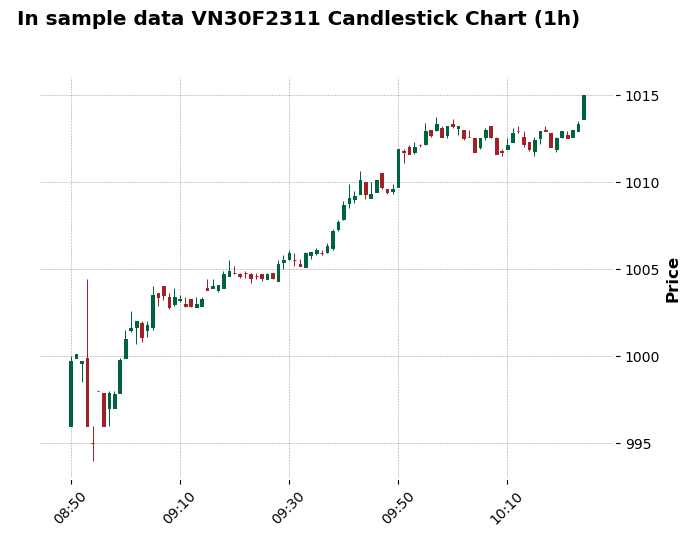

float64
628856 19878
                    tickersymbol    open    high     low   close
datetime                                                        
2023-01-03 08:45:00    VN30F2301   983.0   984.2   934.2   939.0
2023-01-03 08:46:00    VN30F2301   940.0   941.0   940.0   941.0
2023-01-03 08:47:00    VN30F2301   941.8   989.0   941.8   989.0
2023-01-03 08:48:00    VN30F2301   985.0   993.1   985.0   993.1
2023-01-03 08:49:00    VN30F2301   994.0   995.0   994.0   995.0
2023-01-03 08:50:00    VN30F2301   996.0  1000.0   996.0   999.7
2023-01-03 08:51:00    VN30F2301   999.9  1000.1   999.9  1000.1
2023-01-03 08:52:00    VN30F2301   999.6   999.7   998.5   999.7
2023-01-03 08:53:00    VN30F2301   999.9  1004.4   996.0   996.0
2023-01-03 08:54:00    VN30F2301   995.0   996.0   994.0   995.0
2023-01-03 08:55:00    VN30F2301   998.0   998.0   998.0   998.0
2023-01-03 08:56:00    VN30F2301   997.9   997.9   996.0   996.0
2023-01-03 08:57:00    VN30F2301   997.0   998.0   996.0   997.9
2023

In [199]:
# Devide data into in-sample and out-sample
in_sample_dataset = dataset[:int(len(dataset)*0.8)]
out_sample_dataset = dataset[int(len(dataset)*0.8):]

# Chuyển dữ liệu sang DataFrame của in_sample_data
in_sample_candle = pd.DataFrame(in_sample_dataset, columns=['datetime', 'tickersymbol', 'price'])
in_sample_candle['price'] = pd.to_numeric(in_sample_candle['price'], errors='coerce')
print(in_sample_candle['price'].dtype)

# Chuyển đổi cột datetime về kiểu datetime
in_sample_candle['datetime'] = pd.to_datetime(in_sample_candle['datetime'])
in_sample_candle.set_index('datetime', inplace=True)
in_sample_candle['ticker_month'] = in_sample_candle['tickersymbol'].str[-2:].astype(int)

# Create a boolean mask: keep rows if ticker_month <= (datetime month + 1)
mask = in_sample_candle['ticker_month'] <= (in_sample_candle.index.month + 1)

# Filter the DataFrame using the mask
in_sample_candle = in_sample_candle[mask]

# (Optional) Remove the temporary column if no longer needed
in_sample_candle.drop(columns='ticker_month', inplace=True)

# Sort by datetime
in_sample_candle.sort_index(inplace=True)


print(in_sample_candle[130:180])

# Resample dữ liệu theo khung 1 giờ (1h)
in_sample_candle_ohlc = in_sample_candle['price'].resample('1T').ohlc()
in_sample_candle_ohlc = (
    in_sample_candle
    .groupby('tickersymbol')
    .resample('1T')['price']
    .ohlc()
    .reset_index()
)
in_sample_candle_ohlc.set_index('datetime', inplace=True)

# Vẽ biểu đồ nến
mpf.plot(in_sample_candle_ohlc[5:100], type='candle', style='charles',
        title=" In sample data VN30F2311 Candlestick Chart (1h)", ylabel="Price")

# Chuyển dữ liệu sang DataFrame của in_sample_data
out_sample_candle = pd.DataFrame(out_sample_dataset, columns=['datetime', 'tickersymbol', 'price'])
out_sample_candle['price'] = pd.to_numeric(out_sample_candle['price'], errors='coerce')
print(out_sample_candle['price'].dtype)
# Chuyển đổi cột datetime về kiểu datetime
out_sample_candle['datetime'] = pd.to_datetime(out_sample_candle['datetime'])
out_sample_candle.set_index('datetime', inplace=True)

# Resample dữ liệu theo khung 1 giờ (1h)
out_sample_candle_ohlc = out_sample_candle['price'].resample('5t').ohlc()


# Vẽ biểu đồ nến
# mpf.plot(out_sample_candle_ohlc[-50:], type='candle', volume=True, style='charles',
#         title=" Out sample data VN30F2311 Candlestick Chart (1h)", ylabel="Price", ylabel_lower="Volume")

print(len(in_sample_candle_ohlc), len(out_sample_candle_ohlc))
print(in_sample_candle_ohlc[0:50])
print(out_sample_candle_ohlc[-10:])

## 2. Trading Algorithm & Backtesting

In [ ]:
import pandas as pd
import numpy as np
# Calculate SMA(50) on the 'close' column.
# Missing candles are simply not in df – the rolling mean is computed over the nearest 50 available candles.
df = in_sample_candle_ohlc.copy()
df['SMA50'] = df['close'].rolling(window=50, min_periods=50).mean()
print(df[50:100])
position = None  # Will hold a dict with keys: type, entry_price, entry_time
trades = []      # List of dicts for each trade
def open_position(position_type, entry_price, entry_time):
    global position
    position = {
        'type': position_type,  # 'long' or 'short'
        'entry_price': entry_price,
        'entry_time': entry_time
    }
    
def close_position(exit_price, exit_time):
    global position, trades
    if position is None:
        return
    trade = position.copy()
    trade['exit_price'] = exit_price
    trade['exit_time'] = exit_time
    if position['type'] == 'long':
        trade['profit'] = exit_price - position['entry_price']
    else:  # For a short position
        trade['profit'] = position['entry_price'] - exit_price
    trades.append(trade)
    print(f"Closed {position['type']} position at {exit_price} on {exit_time} with profit {trade['profit']}")
    position = None

                    tickersymbol    open    high     low   close     SMA50
datetime                                                                  
2023-01-03 09:35:00    VN30F2301  1005.9  1006.2  1005.8  1006.1  1000.830
2023-01-03 09:36:00    VN30F2301  1005.9  1006.1  1005.8  1005.9  1002.128
2023-01-03 09:37:00    VN30F2301  1006.0  1006.5  1005.9  1006.3  1002.474
2023-01-03 09:38:00    VN30F2301  1006.2  1007.3  1006.1  1007.2  1002.756
2023-01-03 09:39:00    VN30F2301  1007.3  1007.8  1007.2  1007.7  1003.010
2023-01-03 09:40:00    VN30F2301  1007.9  1008.9  1007.8  1008.7  1003.190
2023-01-03 09:41:00    VN30F2301  1008.8  1009.9  1008.5  1009.1  1003.370
2023-01-03 09:42:00    VN30F2301  1009.0  1009.5  1008.8  1009.2  1003.560
2023-01-03 09:43:00    VN30F2301  1009.3  1010.6  1009.3  1010.1  1003.842
2023-01-03 09:44:00    VN30F2301  1010.0  1010.0  1009.0  1009.3  1004.128
2023-01-03 09:45:00    VN30F2301  1009.1  1010.0  1009.1  1009.3  1004.354
2023-01-03 09:46:00    VN

In [ ]:
for i in range(0, len(df)):
    current_candle = df.iloc[i]
    current_time = df.index[i]
    
    # --- Overnight position closing ---
    # If the current candle's date is different from the previous candle's date,
    # close any open position at the previous candle's close.
    if i > 0:
        prev_time = df.index[i-1]
        if current_time.date() != prev_time.date() and position is not None:
            close_position(df.iloc[i-1]['close'], prev_time)
    
    # --- Check for exit conditions if a position is open ---
    if position is not None:
        if position['type'] == 'long':
            unrealized_profit = current_candle['close'] - position['entry_price']
        else:  # For a short position:
            unrealized_profit = position['entry_price'] - current_candle['close']
        # Exit if take profit (>= 3 points) or stop loss (<= -1 point) is reached.
        if unrealized_profit >= 3 or unrealized_profit <= -1:
            close_position(current_candle['close'], current_time)
            continue  # Skip further processing for this candle
    
    # --- If no position, check for an entry signal ---
    if position is None:
        # First, ensure that the three candles before the current one are consecutive (5 mins apart).
        consecutive3 = (
            i >= 3 and
            (current_time - df.index[i-1] == pd.Timedelta(minutes=1)) and 
            (df.index[i-1] - df.index[i-2] == pd.Timedelta(minutes=1)) and
            (df.index[i-2] - df.index[i-3] == pd.Timedelta(minutes=1)) and 
            (df.iloc[i]['tickersymbol'] == df.iloc[i-1]['tickersymbol'] == df.iloc[i-2]['tickersymbol'] == df.iloc[i-3]['tickersymbol'])
        )
        consecutive4 = (
            i >= 4 and
            (current_time - df.index[i-1] == pd.Timedelta(minutes=1)) and
            (df.index[i-1] - df.index[i-2] == pd.Timedelta(minutes=1)) and
            (df.index[i-2] - df.index[i-3] == pd.Timedelta(minutes=1)) and
            (df.index[i-3] - df.index[i-4] == pd.Timedelta(minutes=1)) and
            (df.iloc[i]['tickersymbol'] == df.iloc[i-1]['tickersymbol'] == df.iloc[i-2]['tickersymbol'] == df.iloc[i-3]['tickersymbol'] == df.iloc[i-4]['tickersymbol'])
        )
        if consecutive3:
            # Get the previous three candles
            prev_candles = df.iloc[i-3:i]
            # Define bearish (red) candle as close < open, bullish (green) as close > open.
            bearish_pattern = all(row['close'] < row['open'] for _, row in prev_candles.iterrows())
            bullish_pattern = all(row['close'] > row['open'] for _, row in prev_candles.iterrows())
            # Ensure SMA50 for current candle is not NaN.
            if np.isnan(current_candle['SMA50']):
                continue
            
            # Entry Signal for Buy (Long): Revert trend up
            # If previous 3 candles are bearish, and the previous candle’s high is below current candle’s close,
            # and the current candle’s close is above the SMA50.
            if bearish_pattern and (df.iloc[i-1]['high'] < current_candle['close']) and (current_candle['SMA50'] < current_candle['close']):
                open_position('long', current_candle['close'], current_time)
            
            # Entry Signal for Sell (Short): Revert trend down
            # If previous 3 candles are bullish, and the previous candle’s low is above current candle’s close,
            # and the current candle’s close is below the SMA50.
            elif bullish_pattern and (df.iloc[i-1]['low'] > current_candle['close']) and (current_candle['SMA50'] > current_candle['close']):
                open_position('short', current_candle['close'], current_time)
            elif consecutive4:
                # Get the previous four candles
                prev_candles = df.iloc[i-4:i-1]
                nearest_candle = df.iloc[i-1]
                # Define bearish (red) candle as close < open, bullish (green) as close > open.
                revert_bearish_pattern = all(row['close'] < row['open'] for _, row in prev_candles.iterrows()) and nearest_candle['close'] > nearest_candle['open']
                revert_bullish_pattern = all(row['close'] > row['open'] for _, row in prev_candles.iterrows()) and nearest_candle['close'] < nearest_candle['open']
                # Ensure SMA50 for current candle is not NaN.
                if np.isnan(current_candle['SMA50']):
                    continue

                # Entry Signal for Buy (Long): Continuation trend up
                # If pre-previous 3 candles are bearish, and the nearest candle is bullish, but the previous candle’s high is below current candle’s close,
                # and the current candle’s close is above the SMA50.
                if revert_bullish_pattern and (df.iloc[i-1]['high'] < current_candle['close']) and (current_candle['SMA50'] < current_candle['close']):
                    open_position('long', current_candle['close'], current_time)

                # Entry Signal for Sell (Short): Continuation trend down
                # If previous 3 candles are bullish, and the previous candle’s low is above current candle’s close,
                # and the current candle’s close is below the SMA50.
                elif revert_bearish_pattern and (df.iloc[i-1]['low'] > current_candle['close']) and (current_candle['SMA50'] > current_candle['close']):
                    open_position('short', current_candle['close'], current_time)

# --- End of backtest loop ---
# If any position remains open at the end of the data, close it using the last candle's close.
if position is not None:
    close_position(df.iloc[-1]['close'], df.index[-1])

# =============================================================================
# Trade Summary
# =============================================================================
trades_df = pd.DataFrame(trades)
print("\nBacktesting completed. Trade summary:")
print(trades_df)
total_profit = trades_df['profit'].sum()
print(f"Total profit: {total_profit:.2f}")

Closed long position at 1010.5 on 2023-01-03 10:32:00 with profit -1.6000000000000227
Closed long position at 1017.2 on 2023-01-03 11:06:00 with profit 3.2000000000000455
Closed short position at 1016.2 on 2023-01-03 13:00:00 with profit -1.5
Closed long position at 1026.8 on 2023-01-03 14:21:00 with profit -2.7000000000000455
Closed short position at 1045.0 on 2023-01-04 10:14:00 with profit -1.0
Closed short position at 1046.5 on 2023-01-04 13:08:00 with profit -1.0
Closed short position at 1046.3 on 2023-01-05 11:18:00 with profit 3.1000000000001364
Closed long position at 1062.7 on 2023-01-06 10:47:00 with profit -1.099999999999909
Closed long position at 1053.0 on 2023-01-10 10:36:00 with profit -1.0
Closed long position at 1063.0 on 2023-01-11 10:05:00 with profit -1.0
Closed long position at 1067.2 on 2023-01-11 10:28:00 with profit 3.2000000000000455
Closed short position at 1073.0 on 2023-01-13 10:20:00 with profit -1.400000000000091
Closed short position at 1067.6 on 2023-01-

## 4. Evaluation

### 4.1 Asset Over Time
Asset over time is a simple and intuitive way to show if the algorithm works. If your asset increased, you're doing something right and vice versa. Just simply record the asset through the period of trading, here is the period of backtesting and plot it.

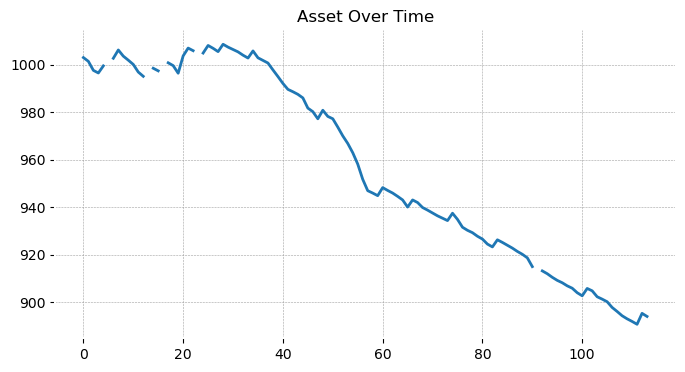

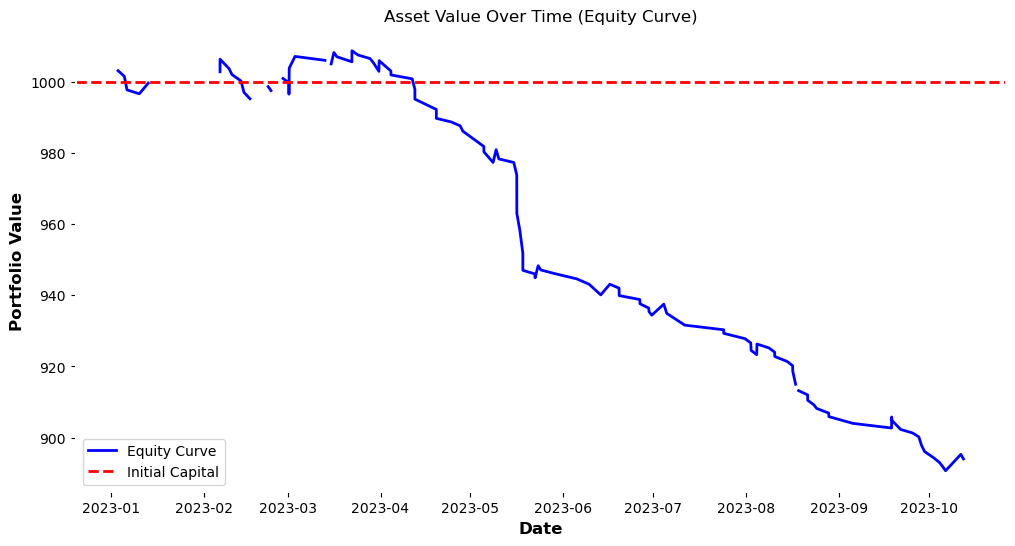

In [184]:
# Set initial capital
initial_capital = 1000 # Example starting balance

# Convert trades into a DataFrame
trades_df = pd.DataFrame(trades)


# Compute cumulative profit
trades_df["capital_over_time"] = initial_capital + trades_df["profit"].cumsum()

trades_df["capital_over_time"].plot(kind='line', figsize=(8, 4), title='Asset Over Time')
plt.gca().spines[['top', 'right']].set_visible(False)

# Plot asset value over time
plt.figure(figsize=(12, 6))
plt.plot(trades_df["exit_time"], trades_df["capital_over_time"], label="Equity Curve", color="b")
plt.axhline(y=initial_capital, color="r", linestyle="--", label="Initial Capital")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Asset Value Over Time (Equity Curve)")
plt.legend()
plt.grid()
plt.show()

### 4.2 Holding Period Return

We can also calculate the rate of return during the considered period

In [137]:
final_capital = initial_capital + trades_df["profit"].sum()

# Compute Holding Period Return
HPR = ((final_capital - initial_capital) / initial_capital) * 100

print(f"Holding Period Return (HPR): {HPR:.2f}%")

Holding Period Return (HPR): 0.14%


### 4.3 Maximum Drawdown (MDD)

Maximum Drawdown (MDD) is also a great tool for assessing the maximum theoretical risk. We can calculate the MDD below.

In [138]:
# Compute capital over time
trades_df["capital_over_time"] = initial_capital + trades_df["profit"].cumsum()

# Calculate the running maximum of the portfolio
running_max = trades_df["capital_over_time"].cummax()

# Compute Drawdown (Difference from peak)
drawdown = running_max - trades_df["capital_over_time"]

# Compute Maximum Drawdown (MDD)
max_drawdown = drawdown.max()

# Convert to percentage
MDD_percentage = (max_drawdown / running_max.max()) * 100

print(f"Maximum Drawdown (MDD): {MDD_percentage:.2f}%")

Maximum Drawdown (MDD): 0.06%


### 4.4 Sharpe ratio

We have shown that the `Sharpe Ratio` is also a great tool to evaluate the compromising between reward and risk. We show the `Sharpe Ratio` of the SMA Trading algorithm in this section.

In [185]:

if not trades:
    sharpe_ratio = "No trades executed, Sharpe Ratio cannot be calculated."
else:
    # Convert trade list to DataFrame
    trades_df = pd.DataFrame(trades)
    trades_df = trades_df.dropna(subset=["exit_time"]).copy()
    trades_df.sort_values(by="exit_time", inplace=True)
    trades_df.reset_index(drop=True, inplace=True)
    initial_capital = 10000  # or whatever your starting balance is

    # Cumulative sum of all profits up to each trade
    trades_df["cumulative_profit"] = trades_df["profit"].cumsum()

    # The portfolio's capital at each trade exit
    trades_df["capital"] = initial_capital + trades_df["cumulative_profit"]
    trades_df["date"] = trades_df["exit_time"].dt.floor("D")
    daily_equity = trades_df.groupby("date")["capital"].last()
    all_days = pd.date_range(start=daily_equity.index.min(),
                         end=daily_equity.index.max(),
                         freq="D")
    daily_equity = daily_equity.reindex(all_days, method="ffill")
    risk_free_rate_annual = 0.03  # 3%
    trading_days_per_year = 252
    daily_returns = daily_equity.pct_change().fillna(0)
    # Convert annual risk-free to daily
    daily_rf = risk_free_rate_annual / trading_days_per_year

    # Excess returns = daily_returns - daily_rf
    excess_returns = daily_returns - daily_rf

    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()

    sharpe_ratio = (mean_excess_return / std_excess_return) * np.sqrt(trading_days_per_year) \
        if std_excess_return != 0 else np.nan

    print("Daily-based Sharpe Ratio:", sharpe_ratio)


Daily-based Sharpe Ratio: -14.497953021107591
